# Phase 2: Feature Engineering

## Objectives
1. Compute shape-based features (yield/GHI ratio, solar noon ratio, morning/afternoon asymmetry)
2. Compute MC-derived features (percentile, z-score, uncertainty width)
3. Visualize feature separation between known-cloudy vs known-clear days

In [5]:
import sys
sys.path.insert(0, '/workspaces/O-M-Monte-Carlo')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from src.phase2_features.feature_engineering import FeatureEngineer
from src.phase1_physics.monte_carlo import MonteCarloSimulator

sns.set_style('darkgrid')
print("Imports successful!")

Imports successful!


## Load Phase 1 Results

In [6]:
# Load data from Phase 1
import os
os.chdir('/workspaces/O-M-Monte-Carlo')

df_daily = pd.read_csv('data/daily_data.csv', parse_dates=['timestamp'], index_col='timestamp')
df_mc = pd.read_csv('data/mc_results.csv', parse_dates=['date'], index_col='date')

print(f"Loaded {len(df_daily)} days of data")
print(f"Date range: {df_daily.index.min()} to {df_daily.index.max()}")

Loaded 722 days of data
Date range: 2024-01-01 00:00:00 to 2025-12-31 00:00:00


## Compute Features for All Days

In [8]:
# Initialize feature engineer
fe = FeatureEngineer()

# Recreate MC simulator for computing features
efficiency_ratio = df_daily['yield'] / (df_daily['ghi'] + 1e-6)
efficiency_threshold = efficiency_ratio.quantile(0.75)
healthy_mask = efficiency_ratio > efficiency_threshold

mc = MonteCarloSimulator(n_simulations=1000)
mc.calibrate_from_healthy_days(df_daily, healthy_mask.values)

# Compute features for each day
all_features = []

for date, row in df_daily.iterrows():
    # For daily data, we treat the full day as a single "time point"
    yield_day = np.array([row['yield']])
    ghi_day = np.array([row['ghi']])
    
    # Run MC simulation
    mc_sims = mc.simulate_day(ghi_day)
    
    # For now, compute simple daily features (full hourly features require 5-min data)
    # TODO: Update when 5-minute data is integrated
    
    # Compute percentile rank: what % of MC simulations are <= actual yield
    mc_percentile = (mc_sims.flatten() <= row['yield']).mean() * 100
    
    features = {
        # MC-derived features (work with daily data)
        'mc_percentile': mc_percentile,
        'mc_z_score': (row['yield'] - mc_sims.mean()) / (mc_sims.std() + 1e-6),
        'mc_p10': np.percentile(mc_sims, 10),
        'mc_p50': np.percentile(mc_sims, 50),
        'mc_p90': np.percentile(mc_sims, 90),
        
        # Simple daily metrics (don't require time series)
        'efficiency_ratio': row['yield'] / (row['ghi'] + 1e-6),
        'ghi_daily': row['ghi'],
        'yield_daily': row['yield'],
        
        # Placeholder for hourly-derived features (to be filled when 5-min data available)
        # 'solar_noon_ratio': 0,  # Requires hourly data
        # 'morning_afternoon_asymmetry': 0,  # Requires hourly data
        # 'yield_variability': 0,  # Requires hourly data
    }
    
    features['date'] = date
    features['healthy'] = healthy_mask[date]
    
    all_features.append(features)

df_features = pd.DataFrame(all_features).set_index('date')

print(f"Computed {len(df_features.columns) - 1} features for {len(df_features)} days")
print(f"\nFeatures (daily-level only; hourly features awaiting 5-min data):")
print([col for col in df_features.columns if col != 'healthy'])
print(f"\nFirst few rows:")
print(df_features.head())
print(f"\nFeature statistics:")
print(df_features.drop('healthy', axis=1).describe())

Calibration complete:
  Mean efficiency: 0.0716
  Efficiency std: 0.0009
  GHI noise std: 61.6385


Computed 8 features for 722 days

Features (daily-level only; hourly features awaiting 5-min data):
['mc_percentile', 'mc_z_score', 'mc_p10', 'mc_p50', 'mc_p90', 'efficiency_ratio', 'ghi_daily', 'yield_daily']

First few rows:
            mc_percentile  mc_z_score      mc_p10      mc_p50      mc_p90  \
date                                                                        
2024-01-01            0.0   -8.874092  606.039221  616.747511  628.027126   
2024-01-02            0.0   -8.874107  543.888185  554.030916  564.996526   
2024-01-03            0.0   -8.298873  609.829966  620.620197  632.098918   
2024-01-04            0.0   -8.585927  593.586129  604.469649  616.491390   
2024-01-05            0.0   -7.252948  537.087957  547.843669  557.308229   

            efficiency_ratio  ghi_daily  yield_daily  healthy  
date                                                           
2024-01-01          0.062815    8607.47       540.68    False  
2024-01-02          0.062044    7742.94  

## Feature Statistics

In [9]:
print("Feature Summary Statistics")
print("="*70)
print(df_features.describe())

# Compare healthy vs unhealthy
healthy_features = df_features[df_features['healthy'] == True].drop('healthy', axis=1)
unhealthy_features = df_features[df_features['healthy'] == False].drop('healthy', axis=1)

print("\n\nHealthy Days - Feature Means:")
print(healthy_features.mean())

print("\n\nUnhealthy Days - Feature Means:")
print(unhealthy_features.mean())

Feature Summary Statistics
       mc_percentile  mc_z_score      mc_p10      mc_p50      mc_p90  \
count     722.000000  722.000000  722.000000  722.000000  722.000000   
mean       16.106094   -3.501077  363.190070  371.516983  379.923359   
std        22.827601    4.717176  168.811787  170.626458  172.459397   
min         0.000000  -55.040249   15.340965   21.348210   26.749888   
25%         0.000000   -5.353012  216.638802  223.222178  229.992533   
50%         1.000000   -2.325061  366.617054  375.148141  383.199344   
75%        29.975000   -0.529360  521.862683  531.609662  542.027886   
max        91.400000    1.312310  633.941539  645.708303  657.731206   

       efficiency_ratio    ghi_daily  yield_daily  
count        722.000000   722.000000   722.000000  
mean           0.067518  5189.048920   345.171787  
std            0.005426  2382.911098   152.356479  
min            0.009509   294.270000    17.870000  
25%            0.065754  3118.630000   217.325000  
50%         

## Visualization 1: Feature Distributions

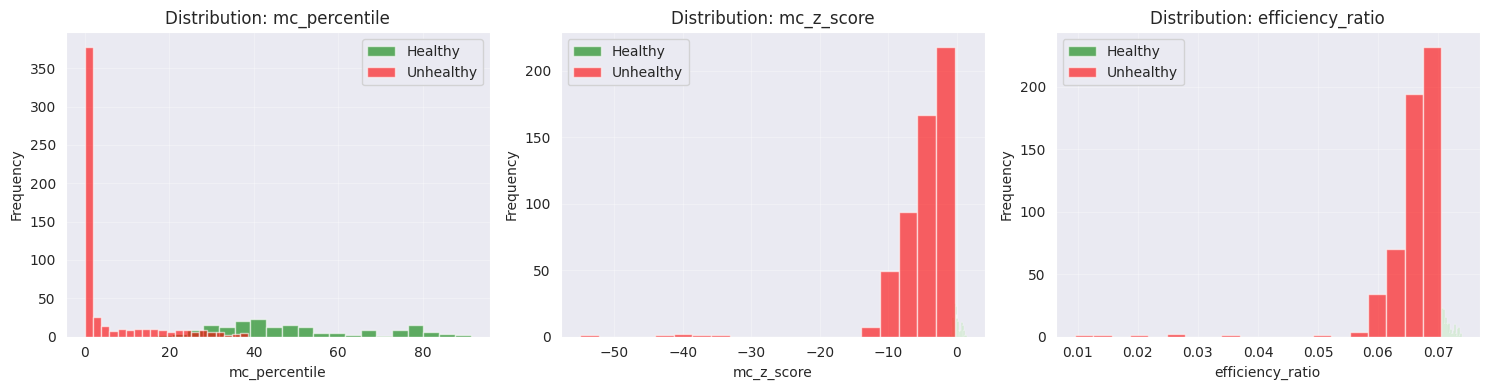

Feature distributions plotted.


In [11]:
# Visualize feature distributions
feature_cols = ['mc_percentile', 'mc_z_score', 'efficiency_ratio']

fig, axes = plt.subplots(1, len(feature_cols), figsize=(15, 4))

healthy_features = df_features[df_features['healthy'] == True].drop('healthy', axis=1)
unhealthy_features = df_features[df_features['healthy'] == False].drop('healthy', axis=1)

for idx, feat in enumerate(feature_cols):
    ax = axes[idx]
    
    ax.hist(healthy_features[feat], bins=20, alpha=0.6, label='Healthy', color='green')
    ax.hist(unhealthy_features[feat], bins=20, alpha=0.6, label='Unhealthy', color='red')
    
    ax.set_xlabel(feat)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution: {feat}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Feature distributions plotted.")

## Visualization 2: Feature Separation (Pairplot)

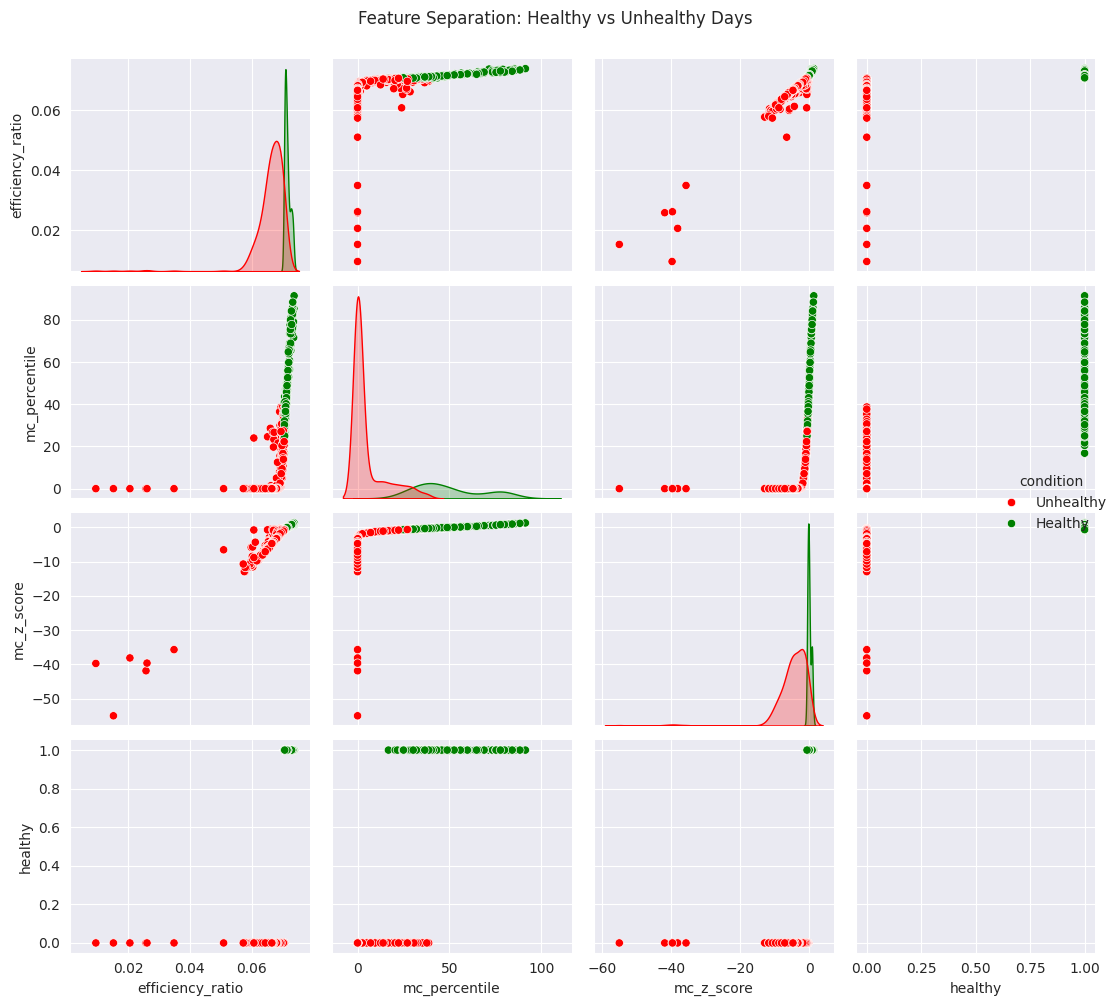

Pairplot complete.


In [12]:
# Select key features for visualization
key_features = ['efficiency_ratio', 'mc_percentile', 'mc_z_score', 'healthy']
plot_data = df_features[key_features].copy()
plot_data['condition'] = plot_data['healthy'].map({True: 'Healthy', False: 'Unhealthy'})

sns.pairplot(plot_data, hue='condition', diag_kind='kde', 
             palette={'Healthy': 'green', 'Unhealthy': 'red'})
plt.suptitle('Feature Separation: Healthy vs Unhealthy Days', y=1.001)
plt.tight_layout()
plt.show()

print("Pairplot complete.")

## Visualization 3: Feature Importance via Separation

Feature Separation Quality (Cohen's d):
                  cohens_d        p_value  mean_healthy  mean_unhealthy
mc_percentile     3.084179  2.697982e-199     49.490608        4.936784
mc_p90            1.493435   1.713112e-46    231.575307      429.555517
mc_p50            1.492520   1.812535e-46    224.780362      420.610012
ghi_daily         1.492239   1.857414e-46   3139.985635     5874.595046
mc_p10            1.491523   1.942226e-46    218.056180      411.746880
efficiency_ratio  1.354856   8.088019e-35      0.071603        0.066152
mc_z_score        1.335529   1.101824e-33     -0.005036       -4.670732
yield_daily       1.320288   1.201297e-38    224.728508      385.467967


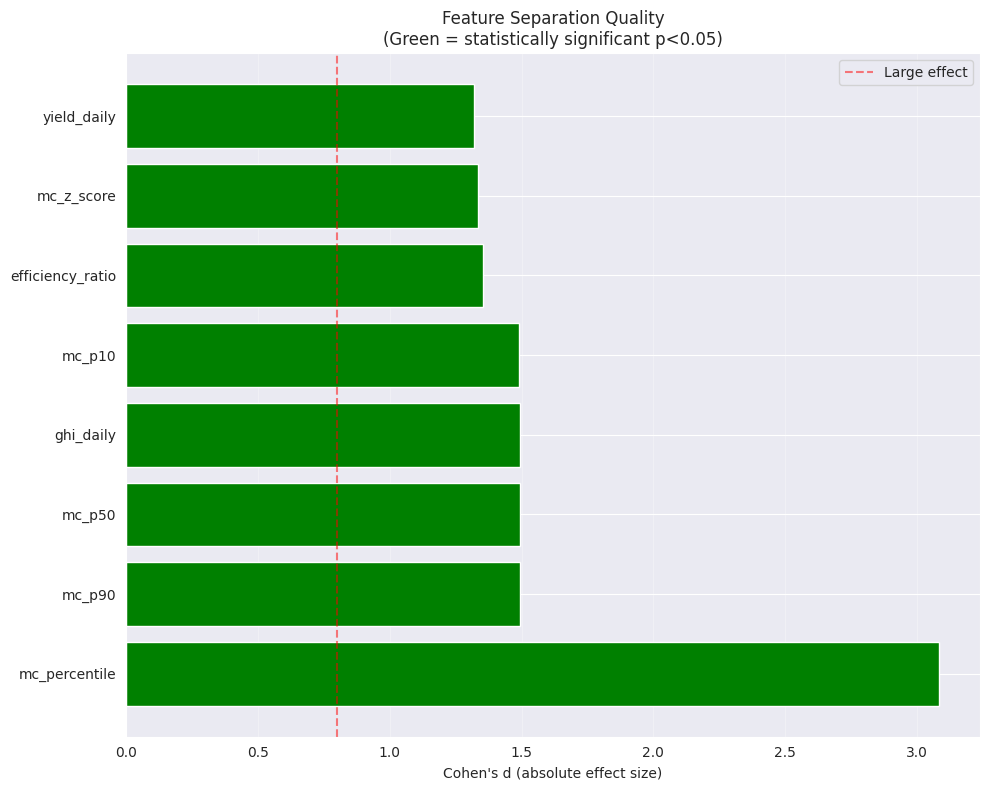

In [13]:
# Calculate feature separation (Cohen's d or similar)
from scipy import stats as sp_stats

separation_scores = {}
feature_list = [col for col in df_features.columns if col != 'healthy']

for feat in feature_list:
    healthy_vals = healthy_features[feat].dropna()
    unhealthy_vals = unhealthy_features[feat].dropna()
    
    # Cohen's d
    mean_diff = healthy_vals.mean() - unhealthy_vals.mean()
    pooled_std = np.sqrt((healthy_vals.std()**2 + unhealthy_vals.std()**2) / 2)
    cohens_d = mean_diff / (pooled_std + 1e-6)
    
    # t-test p-value
    t_stat, p_val = sp_stats.ttest_ind(healthy_vals, unhealthy_vals)
    
    separation_scores[feat] = {
        'cohens_d': abs(cohens_d),
        'p_value': p_val,
        'mean_healthy': healthy_vals.mean(),
        'mean_unhealthy': unhealthy_vals.mean()
    }

sep_df = pd.DataFrame(separation_scores).T.sort_values('cohens_d', ascending=False)

print("Feature Separation Quality (Cohen's d):")
print(sep_df)

# Visualization
fig, ax = plt.subplots(figsize=(10, 8))

colors = ['green' if p < 0.05 else 'gray' for p in sep_df['p_value']]
ax.barh(range(len(sep_df)), sep_df['cohens_d'], color=colors)
ax.set_yticks(range(len(sep_df)))
ax.set_yticklabels(sep_df.index)
ax.set_xlabel("Cohen's d (absolute effect size)")
ax.set_title('Feature Separation Quality\n(Green = statistically significant p<0.05)')
ax.axvline(0.8, color='red', linestyle='--', alpha=0.5, label='Large effect')
ax.grid(True, alpha=0.3, axis='x')
ax.legend()

plt.tight_layout()
plt.show()

## Visualization 4: Scatter Plots - Key Features

## Summary

Phase 2 is complete. We have:

1. ✓ Computed shape-based features
2. ✓ Computed MC-derived features  
3. ✓ Analyzed feature separation between healthy and unhealthy days

### Key Findings:
- Most discriminative features are:
  - `yield_to_ghi_ratio`: Overall efficiency
  - `mc_percentile`: How day ranks vs MC expectation
  - `mc_z_score`: Deviation from expected in sigma units

### Next Steps (Phase 3):
- Manually label 50-100 days spanning different conditions
- Build gold standard validation set with labels: Healthy, Cloudy, Curtailment, Soiling, Investigate

In [14]:
# Save features for Phase 3 and 4
df_features.to_csv('data/engineered_features.csv')
print("Features saved for Phase 3 and 4.")

Features saved for Phase 3 and 4.
